## imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
pd.options.display.float_format = '{:.4f}'.format
%matplotlib inline

## methods

In [5]:
y_true = np.array([1,0,0])
y_pred = np.array([0.99999999, 0.000000001, 0.00000001])

def binary_cross_entropy(y_true, y_pred):
    return (y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred)).mean() *-1

binary_cross_entropy(y_true, y_pred)

7.0000000575710855e-09

In [32]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

def plotCorrelationMatrix(df, graphWidth):
  filename = df.dataframeName
  df = df.dropna('columns') # drop columns with NaN
  df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
  if df.shape[1] < 2:
      print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
      return
  corr = df.corr()
  plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
  corrMat = plt.matshow(corr, fignum = 1)
  plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
  plt.yticks(range(len(corr.columns)), corr.columns)
  plt.gca().xaxis.tick_bottom()
  plt.colorbar(corrMat)
  plt.title(f'Correlation Matrix for {filename}', fontsize=15)
  plt.show()

def plotScatterMatrix(df, plotSize, textSize):
  df = df.select_dtypes(include =[np.number]) # keep only numerical columns
  # Remove rows and columns that would lead to df being singular
  df = df.dropna('columns')
  df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
  columnNames = list(df)
  if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
      columnNames = columnNames[:10]
  df = df[columnNames]
  ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
  corrs = df.corr().values
  for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
      ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
  plt.suptitle('Scatter and Density Plot')
  plt.show()

## Get the data

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv("noshows.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0000,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0000,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0000,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0000,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0000,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [8]:
df["No-show"].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

In [9]:
df["No-show"] = df["No-show"].map({"Yes":0, "No": 1})
df["Gender"] = df["Gender"].map({"M":0, "F": 1})


In [10]:
df["ScheduledDay"] = df["ScheduledDay"].astype('datetime64[ns]').dt.date
df["AppointmentDay"] = df["AppointmentDay"].astype('datetime64[ns]').dt.date
(df["AppointmentDay"][0] - df["ScheduledDay"][0]).days

df["scheduled_days_before"] = (df["AppointmentDay"] - df["ScheduledDay"]).apply(lambda l: l.days)
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,scheduled_days_before
0,29872499824296.0000,5642903,1,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0
1,558997776694438.0000,5642503,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0
2,4262962299951.0000,5642549,1,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0


In [ ]:
# dfg = df.groupby('Neighbourhood')['PatientId'].count().reset_index(name="count")
# dfg[dfg['count'] > 1000]
# df['']
dfg = df.groupby('Neighbourhood').filter(lambda x: len(x) > 1000)
dfg
dfg.plot(kind='bar')
#plt.xlabel('Neighbourhood')
#plt.ylabel('Count')
#plt.title('Appointments by Neighbourhood')
plt.show()
  


In [ ]:
df_train, df_test = split(df, train_size=0.7, random_state=0)
df_train.head()

In [11]:
df.shape


(110527, 15)

In [12]:
#sns.pairplot(df)

## connection between schedule_days_before and appointment id 
## handcap had 0/1/2/3/4 while it should be only true/false

(0.0, 100.0)

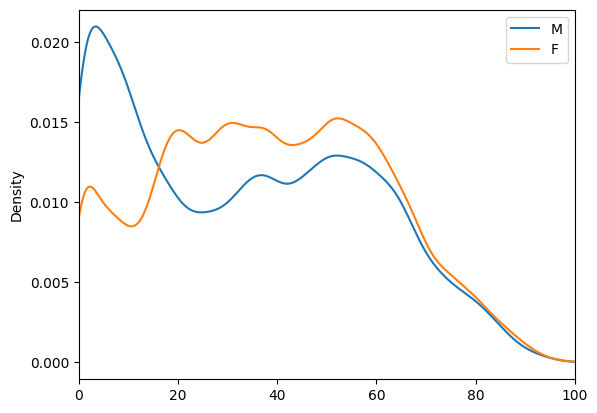

In [13]:
df.groupby('Gender').Age.plot(kind='kde' )
plt.legend(["M","F"])
plt.xlim([0, 100])

<Axes: ylabel='Density'>

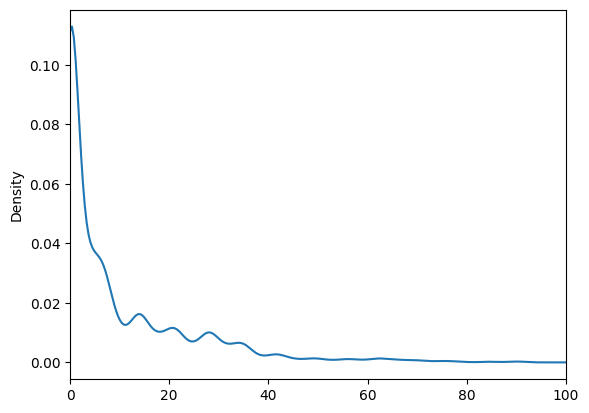

In [14]:
plt.xlim([0, 100])
df.scheduled_days_before.plot(kind='kde' )

In [15]:
df["ScheduledDay"].min(), df["ScheduledDay"].max()


(datetime.date(2015, 11, 10), datetime.date(2016, 6, 8))

In [16]:
df["AppointmentDay"].min(), df["AppointmentDay"].max()

(datetime.date(2016, 4, 29), datetime.date(2016, 6, 8))

In [17]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,scheduled_days_before
0,29872499824296.0000,5642903,1,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0
1,558997776694438.0000,5642503,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0
2,4262962299951.0000,5642549,1,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0
3,867951213174.0000,5642828,1,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0
4,8841186448183.0000,5642494,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0


In [18]:

df_train, df_test = split(df, train_size=0.7, random_state=0)
df_train.head()



,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,scheduled_days_before
108316,62694127837814.0000,5636952,1,2016-04-28,2016-06-03,29,MARIA ORTIZ,0,0,0,0,0,1,0,36
104814,77671385192341.0000,5767854,0,2016-06-03,2016-06-07,46,SÃO PEDRO,0,1,0,0,0,1,0,4
57895,5821115267896.0000,5650380,1,2016-05-03,2016-05-20,25,CONQUISTA,0,0,0,0,0,0,0,17
25669,581554494351133.0000,5613521,0,2016-04-25,2016-05-06,12,BOA VISTA,0,0,0,0,0,1,1,11
29717,159922545943736.0000,5706776,1,2016-05-17,2016-05-17,26,SÃO PEDRO,0,0,0,0,0,0,1,0


In [19]:
X_cols = ["Gender", "Age","scheduled_days_before","SMS_received"]

X_train, X_test = df_train[X_cols], df_test[X_cols]
y_train, y_test = df_train["No-show"], df_test["No-show"]


In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_train

108316    0
104814    0
57895     0
25669     1
29717     1
         ..
21243     1
45891     1
42613     0
43567     1
68268     1
Name: No-show, Length: 77368, dtype: int64

In [22]:
y_pred = clf.predict_proba(X_test)
y_pred = pd.DataFrame(y_pred, index = X_test.index, columns = clf.classes_)
decisions = y_pred.idxmax(axis=1)

In [23]:
def my_experiment_function(df1, list_of_features, my_model):
  df_train, df_test = train_test_split(df1, random_state=1, test_size=0.2)

  X_train, y_train = df_train[list_of_features],df_train["No-show"]
  X_test, y_test = df_test[list_of_features],df_test["No-show"]
  
  my_model.fit(X_train, y_train)

  y_pred = my_model.predict(X_test)
  score = my_model.score(X_test, y_test)
  return score

list_of_features = ["Gender", "Age","scheduled_days_before","SMS_received"]
score = my_experiment_function(df, list_of_features, LogisticRegression())
print(score)

score = my_experiment_function(df, list_of_features, DecisionTreeClassifier())
print(score)

score = my_experiment_function(df, list_of_features, RandomForestClassifier())
print(score)

score = my_experiment_function(df, list_of_features, SVC())
print(score)

score = my_experiment_function(df, list_of_features, KNeighborsClassifier())
print(score)


0.7966163032660816
0.7612412919569348
0.7731385144304713
0.8002352302542296
0.7655387677553606


In [24]:
df_train, df_test = train_test_split(df, random_state=1, test_size=0.2)
list_of_features = ["Gender", "Age","scheduled_days_before","SMS_received"]

X_train, y_train = df_train[list_of_features],df_train["No-show"]
X_test, y_test = df_test[list_of_features],df_test["No-show"]

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[   68,  4348],
       [  148, 17542]])

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.31      0.02      0.03      4416
           1       0.80      0.99      0.89     17690

    accuracy                           0.80     22106
   macro avg       0.56      0.50      0.46     22106
weighted avg       0.70      0.80      0.72     22106



In [26]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_mean_squared_error").mean()

-0.205799533378265

In [27]:
cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_mean_squared_error")

array([-0.20525869, -0.20645781, -0.20651436, -0.20532685, -0.20543995])

In [28]:
def my_experiment_function(list_of_features, num_repititions=5):
    out = []
    lst_of_models = []
    for i in range(num_repititions):
        X_train, y_train = df_train[list_of_features],df_train["No-show"]
        X_test, y_test = df_test[list_of_features],df_test["No-show"]

        model = LogisticRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        out.append(mse)
        lst_of_models.append(model)
        
    return np.array(out), lst_of_models

list_of_features = ["Gender", "Age","scheduled_days_before","SMS_received"]
mses, lst_of_models = my_experiment_function(list_of_features, num_repititions=100)


In [29]:
for model in lst_of_models:
    print(model.coef_[0])

[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]
[-0.02645479  0.00797325 -0.02276717 -0.34316188]


In [30]:
coefs =[model.coef_ for model in lst_of_models]

#coefs = pd.DataFrame(np.array(coefs), columns = list_of_features)